In [9]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.optimize import minimize, Bounds

In [10]:
#Load in data
flow = pd.read_csv("./FD/Data/flow.csv", header=None)
density = pd.read_csv("./FD/Data/density.csv",header=None)
speed = pd.read_csv("./FD/Data/speed.csv",header=None)

flow = np.array(flow)
density = np.array(density)
speed = np.array(speed)

##ravel funciton basically coonverts the datasets that might come in as contours of data and transferes 
#There should also be a function where we invest the ravel function
# them into a singular column array for all of the detector data albeit it does not index them based on the detector numbers...
flow = flow.ravel()
density = density.ravel()
speed = speed.ravel()

data_dict = {"flow": flow, "density": density, "speed": speed}

df_input = pd.DataFrame(data_dict)

#Testing proceedures - if we want to acces row[0], row[1]..etc, acces item n, from row i, 
#density[i][n] eventually it appears the proccess will be to iterate through these,
#items within the above functions. They also do a random split 80% train, 20% validation


In [16]:
##initial guess on the free-flow-speed
vf = 70
k_jam = 120
params = [vf, k_jam]
##the oscillation here is establishing the bounds to begin searching from.
#think of this as an initial search
oscillation: float = 0.4
#Bounds are the lower and upper bounds from the observed datasets or we can user the oscilation
#is just making 40% offsets of the base values 
## ocould also have this as the min and max value found within the datasets
lb_vf, ub_vf = [params[0]*(1-oscillation), params[0]*(1+oscillation)]
lb_kjam_greenshields, ub_kjam_greenshields = [params[1]*(1-oscillation), params[1]*(1+oscillation)]

#You could eddit this and have the boundary dictionary store all of the boundaries for the variables in the other models
boundary_dict  = {
        "Greenshields": [(int(lb_vf), int(lb_kjam_greenshields)), (int(ub_vf), int(ub_kjam_greenshields))]
        #"other models"
        }

#Bounds is a scipy function 
bounds = Bounds((lb_vf, ub_vf),(lb_kjam_greenshields, ub_kjam_greenshields))


##x0 is our initial guesses
x0 = [int(sum(lb_ub_pair)/2) for lb_ub_pair in zip(boundary_dict['Greenshields'][0], boundary_dict['Greenshields'][1])]
x0 = np.array(x0)

In [18]:
ki = df_input.density
vi = df_input.speed
##the reason behind using args* and not a specific keyword lies within using args with
#the optimization call is that if we feed in all of those arguements in the optimization call
#when we iterate through the different models it can automatically draw them into the optimization
#proccess even if they are not required.

##A perfect example of this is greenshields, realistically, we only need the ki data and vi
#data, one for the fitting and the last for the error estimation, flow is never used.
def Greenshields(params, ki):
    vf, k_jam = params
    return vf*(1 - ki/k_jam)

##Understand how this function works and what is is doing in the solution function below.
def objectives(params):
    predictions = Greenshields(params, ki)
    error = vi-predictions
    return np.sum(error)**2  
#initial params are taken as some proportion of the default vf and k_jam. We simply take the existing vf and a
#base percentage of the jam density
initial_params = [vf, max(df_input.density)*.9]



In [21]:
# calibration
##The idea for this, when this is called we have to supply it with the str of the particular model
#and call the x0 here for the initial solution, since we are interested in the values of the initials x0
#moreover another approach to this is 
##Scipy minimize under the 'trust-constr' mode
solution = minimize(objectives,initial_params,method='trust-constr', bounds = bounds)
#.x are the paramaters from solution.
solution.x

array([ 71.98833412, 116.81878674])

In [33]:
##Generating setwise values of density to be used for the calculation of speed and flow
k = np.linspace(0.001,180,70)
v = []
q = []
v.append(Greenshields(solution.x, k))
#converts a column array to row array
v = np.array(v).flatten()
q = np.array(k*v).flatten()


Text(0.5, 1.0, 'Speed vs. flow')

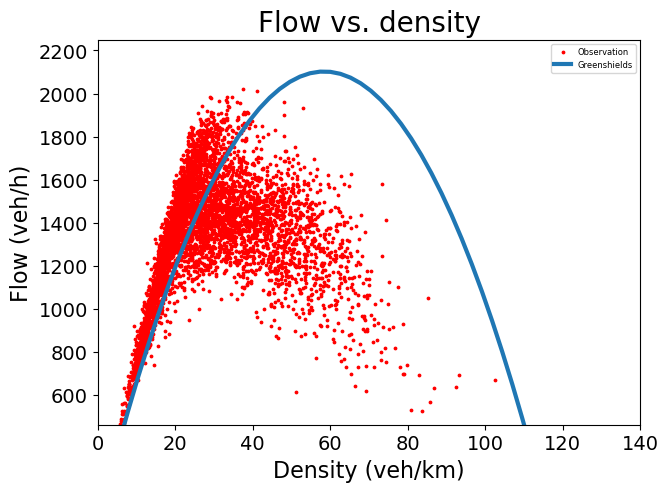

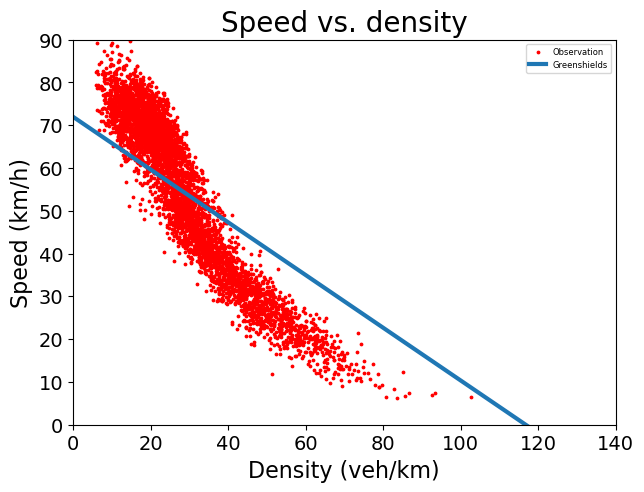

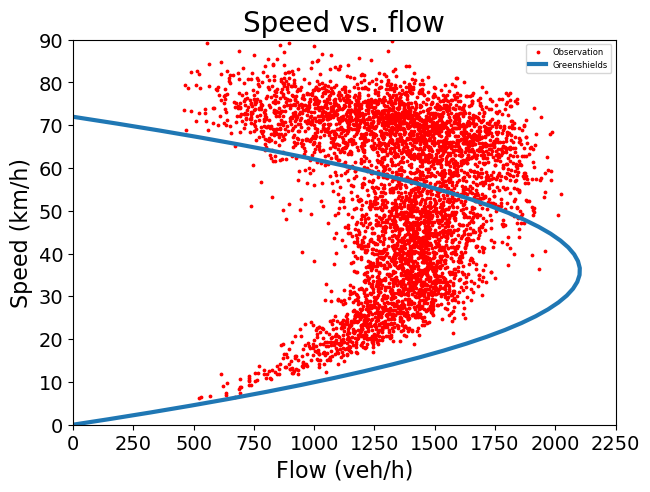

In [34]:
fig = plt.figure(figsize=(7, 5))
plt.scatter(density.flatten(),flow.flatten(), s=3,
                    marker='o', c='r', edgecolors='r', label='Observation')
[plt.plot(k,q,  linewidth=3, label="Greenshields")]
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Density (veh/km)', fontsize=16)
plt.ylabel('Flow (veh/h)', fontsize=16)
plt.xlim((0, 140))
plt.ylim((min(df_input.flow), 2250))
plt.legend(loc='upper right', fontsize=6)
plt.title('Flow vs. density', fontsize=20)

fig = plt.figure(figsize=(7, 5))
plt.scatter(density.flatten(),speed.flatten(), s=3,
                    marker='o', c='r', edgecolors='r', label='Observation')
[plt.plot(k,v,  linewidth=3, label="Greenshields")]
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Density (veh/km)', fontsize=16)
plt.ylabel('Speed (km/h)', fontsize=16)
plt.xlim((0, 140))
plt.ylim((0, 90))
plt.legend(loc='upper right', fontsize=6)
plt.title('Speed vs. density', fontsize=20)

fig = plt.figure(figsize=(7, 5))
plt.scatter(flow.flatten(),speed.flatten(), s=3,
                    marker='o', c='r', edgecolors='r', label='Observation')
[plt.plot(q,v,  linewidth=3, label="Greenshields")]
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Flow (veh/h)', fontsize=16)
plt.ylabel('Speed (km/h)', fontsize=16)
plt.xlim((0, 2250))
plt.ylim((0, 90))
plt.legend(loc='upper right', fontsize=6)
plt.title('Speed vs. flow', fontsize=20)

